<a href="https://colab.research.google.com/github/ashokmuruga/AIMLDL/blob/master/mnist_cossim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customizing the convolution operation of a Conv2D layer

**Author:** [Raphael Pisoni](https://www.rpisoni.dev/)  
**Date created:** 17/01/2022  
**Last modified:** 19/01/2022  
**Description:** Shows how to reach 99% accuracy in MNIST with less than 1,400 parameters using Sharpened Cosine Similarity layers.

In [ ]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [ ]:
## Prepare the data
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalization not necessary with Sharpened Cosine Similarity
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
class CosSim2D(layers.Layer):
    def __init__(self, kernel_size, units=32, stride=1, depthwise_separable=False, padding='valid'):
        super(CosSim2D, self).__init__()
        self.depthwise_separable = depthwise_separable
        self.units = units
        assert kernel_size in [1, 3, 5], "kernel of this size not supported"
        self.kernel_size = kernel_size
        if self.kernel_size == 1:
            self.stack = lambda x: x
        elif self.kernel_size == 3:
            self.stack = self.stack3x3
        elif self.kernel_size == 5:
            self.stack = self.stack5x5
        self.stride = stride
        if padding == 'same':
            self.pad = self.kernel_size // 2
            self.pad_1 = 1
            self.clip = 0
        elif padding == 'valid':
            self.pad = 0
            self.pad_1 = 0
            self.clip = self.kernel_size // 2

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_y = math.ceil((self.in_shape[1] - 2*self.clip) / self.stride)
        self.out_x = math.ceil((self.in_shape[2] - 2*self.clip) / self.stride)
        self.flat_size = self.out_x * self.out_y
        self.channels = self.in_shape[3]
        
        if self.depthwise_separable:
            self.w = self.add_weight(
                shape=(1, tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform", name='w',
                trainable=True,
            )
        else:
            self.w = self.add_weight(
                shape=(1, self.channels * tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform", name='w',
                trainable=True,
            )

        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name='b')

        p_init = tf.keras.initializers.Constant(value=2)

        self.p = self.add_weight(
            shape=(self.units,), initializer=p_init, trainable=True, name='p')
        
    @tf.function
    def l2_normal(self, x, axis=None, epsilon=1e-12):
        square_sum = tf.reduce_sum(tf.square(x), axis, keepdims=True)
        x_inv_norm = tf.sqrt(tf.maximum(square_sum, epsilon))
        return x_inv_norm

    @tf.function
    def sigplus(self, x):
        return tf.nn.sigmoid(x) * tf.nn.softplus(x)

    @tf.function
    def stack3x3(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack(
            [
                tf.pad(image[:, :y-1-self.clip:, :x-1-self.clip, :], tf.constant([[0,0], [self.pad,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],   # top row
                tf.pad(image[:, :y-1-self.clip, self.clip:x-self.clip, :],   tf.constant([[0,0], [self.pad,0], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-1-self.clip, 1+self.clip:, :],  tf.constant([[0,0], [self.pad,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
                
                tf.pad(image[:, self.clip:y-self.clip, :x-1-self.clip, :],   tf.constant([[0,0], [0,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],   # middle row
                image[:,self.clip:y-self.clip:self.stride,self.clip:x-self.clip:self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 1+self.clip:, :],    tf.constant([[0,0], [0,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
                    
                tf.pad(image[:, 1+self.clip:, :x-1-self.clip, :],  tf.constant([[0,0], [0,self.pad], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],    # bottom row
                tf.pad(image[:, 1+self.clip:, self.clip:x-self.clip, :],    tf.constant([[0,0], [0,self.pad], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:, 1+self.clip:, :],   tf.constant([[0,0], [0,self.pad], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:]
            ], axis=3)
        return stack
    
    @tf.function
    def stack5x5(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack(
            [
                tf.pad(image[:, :y-2-self.clip:, :x-2-self.clip, :],          tf.constant([[0,0], [self.pad,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 1:x-1-self.clip, :],         tf.constant([[0,0], [self.pad,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, self.clip:x-self.clip  , :], tf.constant([[0,0], [self.pad,0], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 1+self.clip:-1 , :],         tf.constant([[0,0], [self.pad,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, :y-2-self.clip:, 2+self.clip: , :],           tf.constant([[0,0], [self.pad,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
             
                tf.pad(image[:, 1:y-1-self.clip:,  :x-2-self.clip, :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:,  1:x-1-self.clip, :],         tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:,  self.clip:x-self.clip  , :], tf.constant([[0,0], [self.pad_1,self.pad_1], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:, 1+self.clip:-1  , :],         tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1:y-1-self.clip:, 2+self.clip:  , :],           tf.constant([[0,0], [self.pad_1,self.pad_1], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
                
                tf.pad(image[:, self.clip:y-self.clip,  :x-2-self.clip, :],      tf.constant([[0,0], [0,0], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip,  1:x-1-self.clip, :],     tf.constant([[0,0], [0,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                       image[:, self.clip:y-self.clip,  self.clip:x-self.clip , :][:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 1+self.clip:-1  , :],     tf.constant([[0,0], [0,0], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, self.clip:y-self.clip, 2+self.clip:  , :],       tf.constant([[0,0], [0,0], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
                    
                tf.pad(image[:, 1+self.clip:-1,  :x-2-self.clip, :],           tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1,  1:x-1-self.clip, :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1,  self.clip:x-self.clip  , :],  tf.constant([[0,0], [self.pad_1,self.pad_1], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1, 1+self.clip:-1  , :],          tf.constant([[0,0], [self.pad_1,self.pad_1], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 1+self.clip:-1, 2+self.clip:  , :],            tf.constant([[0,0], [self.pad_1,self.pad_1], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
                    
                tf.pad(image[:, 2+self.clip:,  :x-2-self.clip, :],           tf.constant([[0,0], [0,self.pad], [self.pad,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:,  1:x-1-self.clip, :],          tf.constant([[0,0], [0,self.pad], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:,  self.clip:x-self.clip  , :],  tf.constant([[0,0], [0,self.pad], [0,0], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:, 1+self.clip:-1  , :],          tf.constant([[0,0], [0,self.pad], [self.pad_1,self.pad_1], [0,0]]))[:,::self.stride,::self.stride,:],
                tf.pad(image[:, 2+self.clip:, 2+self.clip:  , :],            tf.constant([[0,0], [0,self.pad], [0,self.pad], [0,0]]))[:,::self.stride,::self.stride,:],
            ], axis=3)
        return stack
    
    def call_body(self, inputs):
        channels = tf.shape(inputs)[-1]
        x = self.stack(inputs)
        x = tf.reshape(x, (-1, self.flat_size, channels * tf.square(self.kernel_size)))
        x_norm = (self.l2_normal(x, axis=2))
        w_norm = (self.l2_normal(self.w, axis=1))
        x = tf.matmul(x / x_norm, self.w / w_norm)
        sign = tf.sign(x)
        x = tf.abs(x) + 1e-12
        x = tf.pow(x  + self.sigplus(self.b), self.sigplus(self.p))
        x = sign * x
        x = tf.reshape(x, (-1, self.out_y, self.out_x, self.units))
        return x
    
    @tf.function
    def call(self, inputs, training=None):
        if self.depthwise_separable:
            channels = tf.shape(inputs)[-1]
            x = tf.vectorized_map(self.call_body, tf.expand_dims(tf.transpose(inputs, (3,0,1,2)), axis=-1))
            s = tf.shape(x)
            x = tf.transpose(x, (1,2,3,4,0))
            x = tf.reshape(x, (-1, self.out_y, self.out_x, self.channels * self.units))
            return x
        else:
            x = self.call_body(inputs)
            return x

In [ ]:
class MaxAbsPool2D(layers.Layer):
    def __init__(self, pool_size, pad_to_fit=False):
        super(MaxAbsPool2D, self).__init__()
        self.pad = pad_to_fit
        self.pool_size = pool_size
        
    def compute_output_shape(self, in_shape):
        if self.pad:
            return (in_shape[0], 
                    tf.math.ceil(in_shape[1] / self.pool_size), 
                    tf.math.ceil(in_shape[2] / self.pool_size), 
                    in_shape[3])
        return (in_shape[0], 
                (in_shape[1] // self.pool_size), 
                (in_shape[2] // self.pool_size), 
                in_shape[3])
        
    
    def compute_padding(self, in_shape):
        mod_y = in_shape[1] % self.pool_size
        y1 = mod_y // 2
        y2 = mod_y - y1
        mod_x = in_shape[2] % self.pool_size
        x1 = mod_x // 2
        x2 = mod_x - x1
        self.padding = ((0,0), (y1, y2), (x1, x2), (0,0))

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_shape = self.compute_output_shape(self.in_shape)
        self.compute_padding(self.in_shape)
    
    @tf.function
    def stack(self, inputs):
        if self.pad:
            inputs = tf.pad(inputs, self.padding)
        batch_size = tf.shape(inputs)[0]
        max_height = (tf.shape(inputs)[1] // self.pool_size) * self.pool_size
        max_width = (tf.shape(inputs)[2] // self.pool_size) * self.pool_size
        stack = tf.stack(
            [inputs[:, i:max_height:self.pool_size, j:max_width:self.pool_size, :] 
             for i in range(self.pool_size) for j in range(self.pool_size)],
        axis=-1)
        return stack
    
    @tf.function
    def call(self, inputs, training=None):
        stacked = self.stack(inputs)
        inds = tf.argmax(tf.abs(stacked), axis=-1, output_type=tf.int32)
        ks = tf.shape(stacked)
        idx = tf.stack([
            *tf.meshgrid(
                tf.range(0, ks[0]), 
                tf.range(0, ks[1]),
                tf.range(0, ks[2]), 
                tf.range(0, ks[3]),
                indexing='ij'
            ), inds], 
            axis=-1)
        
        x = tf.gather_nd(stacked, idx)
        x = tf.reshape(x, (-1, *self.out_shape[1:]))
        return x

In [ ]:
tf.keras.backend.clear_session()

model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Dropout(0.07),
        CosSim2D(3, 10, 1, padding='valid'),
        CosSim2D(1, 10, 1),
        CosSim2D(1, 12, 1),
        layers.Dropout(0.07),
        layers.MaxPool2D((2,2)),
        CosSim2D(3, 2, 1, depthwise_separable=True, padding='same'),
        CosSim2D(1, 8, 1),
        layers.Dropout(0.07),
        layers.MaxPool2D((2,2)),
        CosSim2D(3, 4, 1, depthwise_separable=True),
        CosSim2D(1, 10, 1),
        layers.Dropout(0.07),
        MaxAbsPool2D(2, True),
        layers.Flatten(),
        layers.Dense(num_classes, activation=None),
    ]
)

model.summary()

batch_size = 1024
epochs = 200
checkpoint_path = 'training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


lr = tf.keras.optimizers.schedules.CosineDecay(0.05, decay_steps=(x_train.shape[0] // batch_size) * epochs, alpha=0.00001)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr


optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer=optimizer, metrics=[get_lr_metric(optimizer), "accuracy"], run_eagerly=False)

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 cos_sim2d (CosSim2D)        (None, 26, 26, 10)        110       
                                                                 
 cos_sim2d_1 (CosSim2D)      (None, 26, 26, 10)        120       
                                                                 
 cos_sim2d_2 (CosSim2D)      (None, 26, 26, 12)        144       
                                                                 
 dropout_1 (Dropout)         (None, 26, 26, 12)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 12)       0         
 )                                                               
                                                        

In [ ]:
model.load_weights(checkpoint_dir)
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0350 - lr: 0.0204 - accuracy: 0.9901


[0.0349777415394783, 0.020355693995952606, 0.9901000261306763]

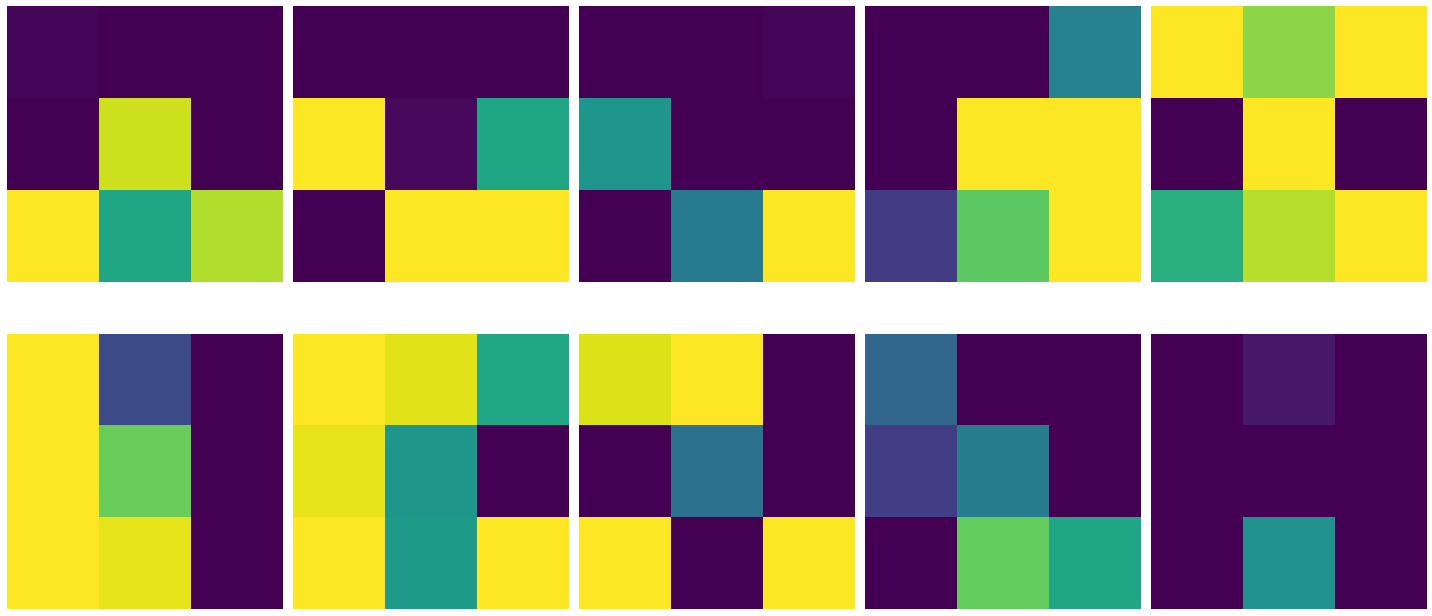

In [ ]:
for i, layer in enumerate(model.layers):
    if layer.name.startswith('cos_sim2d'):
        kernel_layer = i
        break
        
_, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

kernels = []

for i, ax in zip(range(tf.shape(model.layers[kernel_layer].w)[-1]), axs):
    kernel = model.layers[kernel_layer].w[0,:, i]
    side = tf.sqrt(tf.cast(tf.shape(kernel)[0], tf.float32))
    kernel = tf.reshape(kernel, (side,side,1)).numpy()
    kernels.append(kernel)
    ax.imshow(kernel[:,:,0], vmin=-1, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()

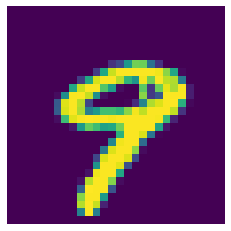

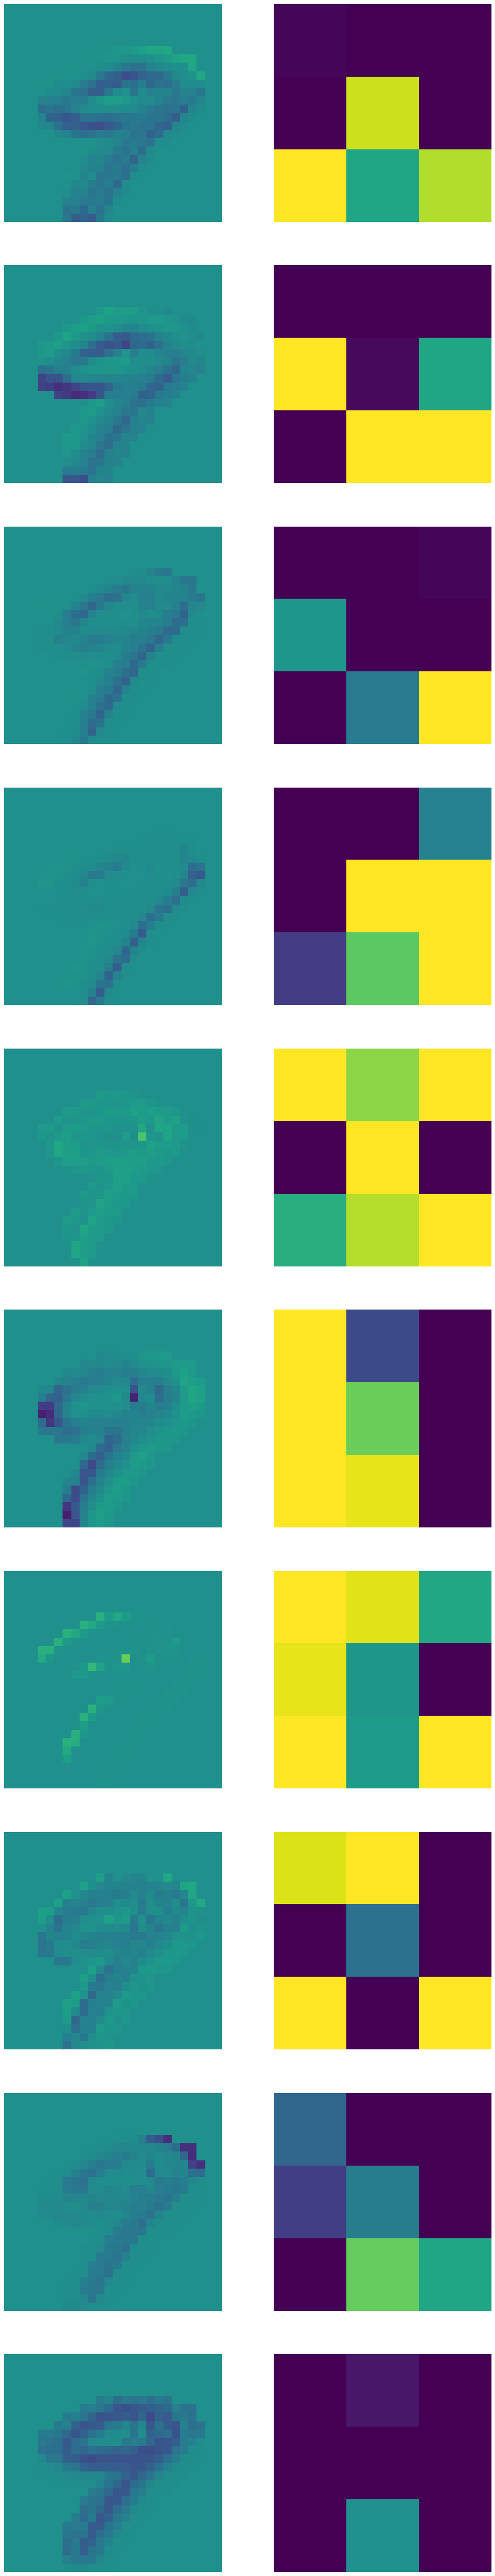

In [ ]:
n = 9
print(layer)
plt.imshow(x_test[n][:,:,0])
plt.axis('off')
plt.show()

activations = layer(x_test[n:n+1])[0].numpy()

_, axs = plt.subplots(nrows=activations.shape[-1], ncols=2, figsize=(15, activations.shape[-1] * 8))

for i in range(10):
    axs[i, 0].imshow(activations[:,:,i], vmin=-1, vmax=1)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(kernels[i][:,:,0], vmin=-1, vmax=1)
    axs[i, 1].axis('off')
plt.tight_layout
plt.show()